# **Imputation recommendation random forest machine learning model**

The imputation algorithm "reccomendation" multiclass machine learning model is the key element in the pipline tool. This model will be trained to take in a set of pre-defined metafeatures (including the feature for which missing data points need imputation) relating to a dataset and return the imputation algorithm that is best used to replace the missing data points in the dataset. Although the model is called a "reccomedation" tool it is a classification task and thus will be a classification model.

In this file the model will be trained, tested and optimised. It will be trained and tested on the results (statistics) obtained from running the imputation algorithms on our stored datasets, these results include the file (for which the metafeatures can be extracted for input) and the name of the imputation algorithm which gave the best estimated imputed values. When testing / validating the model we will be aiming for 70% as per requirement 1.2 of section 3.4 on artefact MoSCoW requirements, testing / validation will be performed visual through the use of line graphs and confusion matrixes aswell as the functional use case testing that is performed. Finally in order to optimise the model various experiment will be performed where the parameters of the model such as the optimiser or loss function to determine the optimal configuration for the model.

# Mounting the Google drive

This allows us to access all the data we store in this project as well at the file system

In [ ]:
# Need to mount drive to access and save files that store model stats, figures, etc
from google.colab import drive
import os


# Mount the drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Final_year_project") # Path of reference for imports
folder = os.path.join("/content/drive/MyDrive/Final_year_project") # Reference for future use when importing / exporting files

# View files in the current working directory
!ls

Mounted at /content/drive
data
datasets
getImputationModelsStats.ipynb
getMissingData.ipynb
imputationRecommendationModel.ipynb
imputationRecommendationModelRandomForest.ipynb
machine_learning_model
pipeline.ipynb
random_forest_machine_learning_model
root


# Imports and installs

This section import and/or installs all neccessary python libraries

In [ ]:
# pip installs
!pip install -U kaleido
!pip install lime
!pip install shap
!pip install visualkeras
!pip install imbalanced-learn
!pip install tf-explain
!pip install tensorflow


# Imports
from datetime import datetime
from google.colab import drive
from pathlib import Path
from tensorflow.keras import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.initializers import GlorotUniform, HeNormal, RandomNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import (
    Dense,
    ZeroPadding2D,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    Input,
    Rescaling,
    RandomFlip,
    RandomRotation,
    RandomZoom,
    Activation,
    AveragePooling2D,
    Add,
    Resizing,
    RandomRotation,
    BatchNormalization
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d
from prettytable import PrettyTable
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from seaborn import heatmap
from tf_explain.core.grad_cam import GradCAM
from lime import lime_image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import json
import pandas as pd
import time
import numpy as np
import random
import os
import shap
import matplotlib.pyplot as plt
import visualkeras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import os
import fnmatch
import gc
import sys
import itertools
import tensorflow as tf
import seaborn as sns
import contextlib
import io
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1b945a70e040dc0efa91933c321b9fab1a3728f71a79e772ff7e6226b9f362c6
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00


# Loading the datasets

In this section create a new function to load the statistics files from each missingness mechansims folder except with the functionality of being able to apply the SMOTE oversampling technique to generate more data to train the model and class balance the datasets or to load the datasets as they are (inbalanced)

In [ ]:
def load_dataset(download_path, imputation_stats_folder, imputation_stats_file, test_size, random_state, is_filtered):


  # Load stats file
  if not os.path.exists(os.path.join(download_path, imputation_stats_folder, imputation_stats_file)):


    return None


  # Load dataset into DataFrame
  with open(os.path.join(download_path, imputation_stats_folder, imputation_stats_file), 'r') as json_data:
    imputation_stats_JSON = json.loads(json_data.read())
    imputation_stats = pd.json_normalize(imputation_stats_JSON)


  # Balance the dataset data - filter by the number of occuerances of the least common algorithm
  if is_filtered:
    min_imputation_algorithm_occurances = np.min(list(imputation_stats["optimal_imputation_algorithm"].value_counts()))
    imputation_stats = imputation_stats.groupby("optimal_imputation_algorithm").head(min_imputation_algorithm_occurances)


  # Seperate into data and labels
  imputation_stats_algorithms_labels = np.array(imputation_stats["optimal_imputation_algorithm"])
  imputation_stats.drop("optimal_imputation_algorithm", axis=1, inplace=True)
  imputation_stats_metafeatures = np.array([row.tolist() for _, row in imputation_stats.iterrows()])

  # shuffle the data
  perm_train = np.random.permutation(len(imputation_stats_metafeatures))
  imputation_stats_metafeatures = imputation_stats_metafeatures[perm_train]
  imputation_stats_algorithms_labels = imputation_stats_algorithms_labels[perm_train]

  # Impute NaN values with 0 before applying SMOTE / Clean the data
  imputation_stats_metafeatures = np.nan_to_num(imputation_stats_metafeatures, nan=0.0, posinf=1.0, neginf=1.0)
  imputation_stats_algorithms_labels = np.nan_to_num(imputation_stats_algorithms_labels, nan=0.0, posinf=1.0, neginf=1.0)


  return imputation_stats_metafeatures, imputation_stats_algorithms_labels




def load_dataset_for_missingness_mechansim(
    mcar_path,
    mar_path,
    mnar_path,
    imputation_stats_folder,
    imputation_stats_file,
    is_oversampled,
    label_encoder,
    test_size,
    random_state,
    is_filtered
  ):

  # Load datasets for each missingness mechansim
  X_mcar_datasets, Y_mcar_datasets = load_dataset(mcar_path, imputation_stats_folder, imputation_stats_file, test_size, random_state, is_filtered)
  X_mar_datasets, Y_mar_datasets = load_dataset(mar_path, imputation_stats_folder, imputation_stats_file, test_size, random_state, is_filtered)
  X_mnar_datasets, Y_mnar_datasets = load_dataset(mnar_path, imputation_stats_folder, imputation_stats_file, test_size, random_state, is_filtered)

  # Convert X and Y to numpy arrays before concatenation
  X = np.concatenate([X_mcar_datasets, X_mar_datasets, X_mnar_datasets])
  Y = np.concatenate([Y_mcar_datasets, Y_mar_datasets, Y_mnar_datasets])

  # Shuffle the data
  perm_train = np.random.permutation(len(X))
  X = X[perm_train]
  Y = Y[perm_train]


  if is_oversampled:
    smote = SMOTE(random_state=42, k_neighbors=4)
    X, Y = smote.fit_resample(X, Y)


  # Split into test / train datasets
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)


  # Display the class balance
  values, counts = np.unique(y_train, return_counts=True)


  for val, count in zip(values, counts):
      print(f"Value: {val}, Count: {count}")


  # Encode labels
  all_labels = np.concatenate([y_train, y_test])
  label_encoder.fit(all_labels)
  labels_encoded = label_encoder.transform(all_labels)
  y_train = labels_encoded[:len(y_train)]
  y_test = labels_encoded[len(y_train):]


  return (X_train, y_train), (X_test, y_test)

#### Testing

In [ ]:
# Load datasets for a missingness mechansim
print("MCAR data:")
mcar_datasets_train, mcar_datasets_test = load_dataset(mcar_path, imputation_stats_folder, imputation_stats_file, 0.2, 42)

print("\nMAR data:")
mcar_datasets_train, mcar_datasets_test = load_dataset(mar_path, imputation_stats_folder, imputation_stats_file, 0.2, 42)

print("\nMNAR data:")
mcar_datasets_train, mcar_datasets_test = load_dataset(mnar_path, imputation_stats_folder, imputation_stats_file, 0.2, 42)

label_encoder = LabelEncoder()
datasets_train, datasets_test, _ = load_dataset_for_missingness_mechansim(mcar_path, mar_path, mnar_path, imputation_stats_folder, imputation_stats_file, False, label_encoder, 0.2, 42)

# Visualisation functions

This section contains functions that can be used to visualise the results of training and validating the machine learning model

In [ ]:
"""Training metrics bar charts figures"""
def graph_metrics(metrics_data, save_fig_folder, image_label):

  # Get metrics
  accuracy = metrics_data["accuracy"]
  precision = metrics_data["precision"]
  recall = metrics_data["recall"]
  f1_score = metrics_data["f1_score"]

  # Create graph
  x = 1
  width = 0.25

  plt.figure(figsize=(8, 5))
  plt.bar(x - 2*width, accuracy, width, label='Accuracy', color='red')
  plt.bar(x - width, precision, width, label='Precision', color='skyblue')
  plt.bar(x, recall, width, label='Recall', color='lightgreen')
  plt.bar(x + width, f1_score, width, label='F1 Score', color='salmon')

  # Labels and legend
  plt.xlabel('Score')
  plt.ylabel('Metric')
  plt.title('Model Performance')
  plt.legend()
  plt.tight_layout()


  # Save image to given folder - should be only one per folder
  if os.path.exists(save_fig_folder):
    plt.savefig(os.path.join(save_fig_folder, image_label))


  # Diplay the graph
  plt.show()


def graph_metric(iteration_data, iteration_titels, save_fig_folder, image_label, color, metric):

  # Get metrics
  metric_list = [iteration[metric] for iteration in iteration_data] # Extract metric, handle missing values

  # Create graph
  x = np.arange(len(iteration_titels))
  width = 0.25

  plt.figure(figsize=(15, 10))
  plt.bar(x, metric_list, width, label=metric, color=color)

  # Labels and legend
  plt.xlabel('Iteration')
  plt.ylabel(f'{metric.title()}')
  plt.title(f'Model Performance by {metric.title()}')
  plt.xticks(x, iteration_titels, rotation=90)
  plt.legend()
  plt.tight_layout()


  # Save image to given folder - should be only one per folder
  if os.path.exists(save_fig_folder):
    plt.savefig(os.path.join(save_fig_folder, image_label))


  plt.show()


def graph_accuracy(iteration_data, iteration_titels, save_fig_folder, image_label):
  graph_metric(iteration_data, iteration_titels, save_fig_folder, image_label, 'red', "accuracy")


def graph_precision(iteration_data, iteration_titels, save_fig_folder, image_label):
  graph_metric(iteration_data, iteration_titels, save_fig_folder, image_label, 'skyblue', "precision")


def graph_recall(iteration_data, iteration_titels, save_fig_folder, image_label):
  graph_metric(iteration_data, iteration_titels, save_fig_folder, image_label, 'lightgreen', "recall")


def graph_f1_score(iteration_data, iteration_titels, save_fig_folder, image_label):
  graph_metric(iteration_data, iteration_titels, save_fig_folder, image_label, 'salmon', "f1_score")




"""Validation stats table figure"""
# Table figure
def graph_iterations_final_stats(iteration_data, iteration_titels, save_fig_folder, image_label):
  iterations_accuracy = iterations_loss = iterations_val_accuracy = iterations_val_loss = []
  iterations_dict = []


  # Get the stats final epochs data point for the current iteration
  for iteration, title in zip(iteration_data, iteration_titels):
    iterations_dict.append(
        {
            'Title': title,
            'Accuracy': np.nan_to_num(iteration["accuracy"], nan=0.0, posinf=1.0, neginf=1.0),
            'Precision': np.nan_to_num(iteration["precision"], nan=0.0, posinf=1.0, neginf=1.0),
            'Recall': np.nan_to_num(iteration["recall"], nan=0.0, posinf=1.0, neginf=1.0),
            'F1 Score': np.nan_to_num(iteration["f1_score"], nan=0.0, posinf=1.0, neginf=1.0)
        }
    )


  iterations_df = pd.json_normalize(iterations_dict)

  fig = go.Figure(
      data=[
          go.Table(
              header=dict(
                  values=list(iterations_df.columns),
                  fill_color='paleturquoise',
                  align='left'
              ),
              cells=dict(
                  values=[iterations_df[col] for col in iterations_df.columns],
                  fill_color='lavender',
                  align='left'
              )
          )
      ]
  )

  fig.update_layout(width=1000)

  fig.show()  # Opens in browser


  # Save image to given folder - should be only one per folder
  if os.path.exists(save_fig_folder):
    fig.write_image(os.path.join(save_fig_folder, image_label))




"""Confusion matrix figure"""
def make_confusion_matrix(unencoded_labels, validation_labels, predictions, save_fig_folder, title, image_label):

  # Confusion matrix
  confusionMatrix = confusion_matrix(validation_labels, predictions)

  # Create visual confusion matrix
  plt.figure(figsize=(10, 10))
  sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=unencoded_labels, yticklabels=unencoded_labels)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(title)
  plt.tight_layout()


  # Save image to given folder - should be only one per folder
  if os.path.exists(save_fig_folder):
    plt.savefig(os.path.join(save_fig_folder, image_label))


  # Diplay the graph
  plt.show()

# Establishing variables

In this section we simply establish all global peices of information we will need for future use

In [ ]:
# Specify the paths to download the datasets
download_path = './datasets'
original_path = "./data/Original"
mcar_path = "./data/MCAR"
mar_path = "./data/MAR"
mnar_path = "./data/MNAR"
imputation_stats_folder = "imputation_stats"
imputation_stats_file = "imputation_stats.json"
machine_learning_folder = "random_forest_machine_learning_model"

# Set model parameters as defualt in initialisation for consistency
test_size = 0.1
random_state = 42
num_estimators = 100
max_depth = 5
min_samples_split = 2
min_samples_leaf = 1
class_names = ["Mean / Mode / Median Imputation",
                   "LOCF Imputation",
                   "NOCF Imputation",
                   "Regression Imputation",
                   "MICE imputation",
                   "MissForest Imputation",
                   "Bayesian Imputation",
                   "kNN Imputation"]
num_classes = len(class_names)
is_oversampled = False
is_weighted = False
is_filtered = False

prev_metrics_dict = []
prev_labels_list = []


class_names = ["Mean / Mode / Median Imputation",
                   "LOCF Imputation",
                   "NOCF Imputation",
                   "Regression Imputation",
                   "MICE imputation",
                   "MissForest Imputation",
                   "Bayesian Imputation",
                   "kNN Imputation"]

# Model
Here we create the functionality to setup, configure and run the model. This functions will train and test the random forest model and return a validation accuracy from the testing of the model

In [ ]:
def model(
    test_size = 0.2,
    random_state = 42,
    num_estimators = 100,
    max_depth = 5,
    min_samples_split = 2,
    min_samples_leaf = 1,
    metrics_save_file = "./",
    is_oversampled = False,
    is_weighted = False,
    is_filtered = False
):
  # Dictionary to log metric and be logged in csv format
  metrics_dict = {}

  # Load data into the model
  label_encoder = LabelEncoder()
  train_dataset, validation_dataset = load_dataset_for_missingness_mechansim(
      mcar_path,
      mar_path,
      mnar_path,
      imputation_stats_folder,
      imputation_stats_file,
      is_oversampled,
      label_encoder,
      test_size,
      random_state,
      is_filtered
  )


  # Train model
  model = None


  if is_weighted:
    model = RandomForestClassifier(
        n_estimators = num_estimators,
        random_state = random_state,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf,
        class_weight = 'balanced'
    )
  else:
    model = RandomForestClassifier(
        n_estimators = num_estimators,
        random_state = random_state,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        min_samples_leaf = min_samples_leaf
    )


  model.fit(train_dataset[0], train_dataset[1])


  # Predict
  y_predictions = model.predict(validation_dataset[0])
  unencoded_labels = np.unique(label_encoder.inverse_transform(train_dataset[1]))


  # Model metrics
  acc = accuracy_score(validation_dataset[1], y_predictions)
  precision = precision_score(validation_dataset[1], y_predictions, average='weighted')
  recall = recall_score(validation_dataset[1], y_predictions, average='weighted')
  f1 = f1_score(validation_dataset[1], y_predictions, average='weighted')

  metrics_dict = {
      'accuracy': acc,
      'precision': precision,
      'recall': recall,
      'f1_score': f1
  }

  # Save Model metrics
  df = pd.DataFrame(metrics_dict, index=[0])
  df.to_csv(metrics_save_file, mode='a', index=False, header=not os.path.exists(metrics_save_file))


  # Classification report
  report = classification_report(validation_dataset[1], y_predictions)
  print(f"Classification Report ---------------------------------------------------- : \n {report}")


  # Final metrics report
  print(f"Final Metrics Report ---------------------------------------------------- : \n")
  print(f"Accuracy: {acc}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")


  return metrics_dict, unencoded_labels, validation_dataset[1], y_predictions

# Model training

In this section we train, test / validation and evaluate the model in its initial / original state (saving the stats of the assessment as well as the model image) This is done so that we have something to compare the future model configurations against when we start performing optimisation experiments.

## Parameter initialisation

Here we initialise the parameters in what would be considered a default state (parameters that arent too big or too small as to not push the model to any kind of extremes)

In [ ]:
#Initialise parameters
test_size = 0.2
random_state = 42
num_estimators = 100
max_depth = 5
min_samples_split = 2
min_samples_leaf = 1
is_oversampled = False
is_weighted = False
is_filtered = False

In [ ]:
# Initialise folders
original_model_metrics_save_folder = os.path.join(machine_learning_folder, "original_model_stats")

metrics_save_file = os.path.join(original_model_metrics_save_folder, "original_model_metrics.csv")

original_model_label = "Orignal model"

# Create folders if they don't exist
if not os.path.exists(original_model_metrics_save_folder):
    os.makedirs(original_model_metrics_save_folder)
    print(f"Folder '{original_model_metrics_save_folder}' created.")


# Run the model
metrics_dict, unencoded_labels, validation_labels, predictions = model(
    test_size = test_size,
    random_state = random_state,
    num_estimators = num_estimators,
    max_depth = max_depth,
    min_samples_split = min_samples_split,
    min_samples_leaf = min_samples_leaf,
    metrics_save_file = metrics_save_file,
    is_oversampled = is_oversampled,
    is_weighted = is_weighted,
    is_filtered = is_filtered
)

Value: Bayesian Imputation, Count: 252
Value: LOCF Imputation, Count: 251
Value: MICE imputation, Count: 32
Value: Mean / Mode / Median Imputation, Count: 54
Value: MissForest Imputation, Count: 110
Value: NOCF Imputation, Count: 444
Value: Regression Imputation, Count: 174
Value: kNN Imputation, Count: 535
Classification Report ---------------------------------------------------- : 
               precision    recall  f1-score   support

           0       0.49      0.42      0.45        69
           1       0.25      0.02      0.03        60
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        14
           4       0.70      0.26      0.38        27
           5       0.41      0.83      0.54       110
           6       0.00      0.00      0.00        46
           7       0.60      0.76      0.67       132

    accuracy                           0.49       464
   macro avg       0.31      0.29      0.26       464
weighted avg    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

# Model Analysis

In this section we perform further assessment of the inital model by visualising the stats returned from the training and testing of the initial model

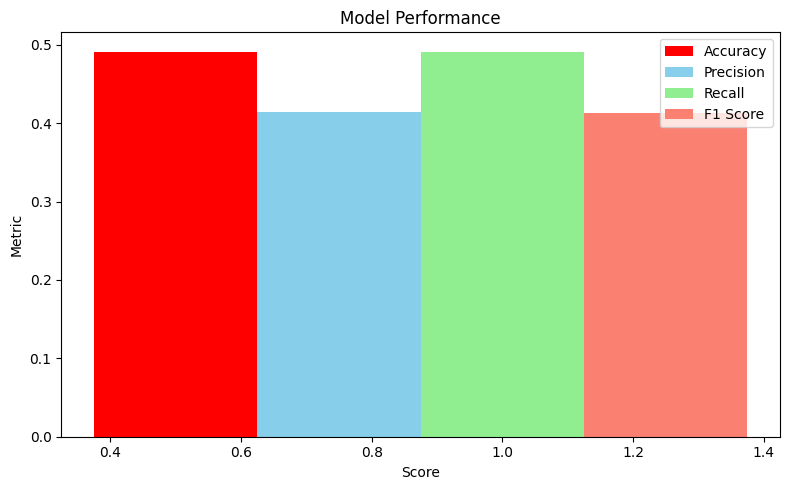

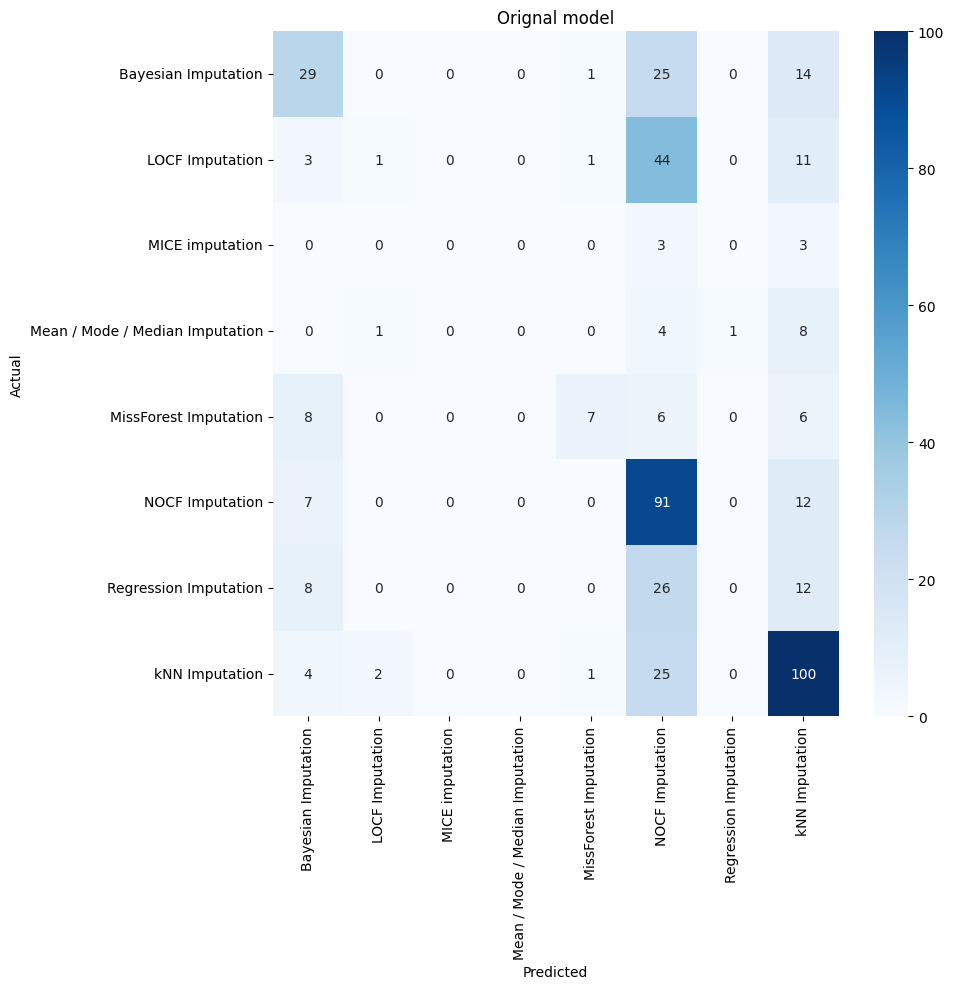

In [ ]:
# Create a bar graph for the inital models metrics
graph_metrics(metrics_dict, original_model_metrics_save_folder, "metrics_graph")

# Create a confusion matrix for the initial model
make_confusion_matrix(unencoded_labels, validation_labels, predictions, original_model_metrics_save_folder, original_model_label, "confusion_matrix.png")

## Results

This training and analysis of the inital model has proved it to already be a more effective machine learning model than the nueral network as it has a baseline accuracy of over 50% without any optimisation experiments being performed. The confusion matrix generated based on the validation data shows that some classess are represented more in the data than others and have a far betters prediction to acutal ration. It is very likely that this is due to the class imbalance in the data.

In [ ]:
# Set the metrics to be used in the next experiment for comparison
prev_metrics_dict.append(metrics_dict)
prev_labels_list.append(original_model_label)

# **Experiments**

In this section we run experiments on the model we have created in an attempt to optimise its performance (accuracy, precision, etc) These experiments will consist of choosing a technique to balance the class imbalace in the datasets (class weighting, SMOTE / oversampling, No balancing) and subjecting the model the data in subseqntly used on to a random search to determine the optimal parameters for the combination of the model and balacing technique. The combination of the model and balacing technique that produces the highest accuracy will be selected as the optimal model and no further optimisation will be performed beyond this point.

## Experiment 1 - No balacing technique

In this experiment we use don't implement any technqiues to balance the data and instead subject the current model (trained, tested and analysed in the previous sections) to a random search to determine the parameters at which it could run optimally. It is unlikely that this should produce the best model due to large amounts of imbalance but it included for the sake of exploring the whole solution space

#### Variable initialisation 1 - No balacing technique

In [ ]:
# Variable initalisation for experiment 1 - No balacing technique

# Initialse variables
no_balacing_model_label = "No balacing model"

# Set folders for the saving of stats, models and figures
experiment1_stats_folder = os.path.join(machine_learning_folder, "experiement1_model_stats")
experiment1_model_folder = os.path.join(machine_learning_folder, "experiement1_model")
metrics_save_file = os.path.join(experiment1_stats_folder, "metrics.csv")
encoded_classess_save_file = os.path.join(experiment1_stats_folder, "encoded_classess.csv")


# Create folders if they don't exist
if not os.path.exists(experiment1_stats_folder):
    os.makedirs(experiment1_stats_folder)
    print(f"Folder '{experiment1_stats_folder}' created.")


if not os.path.exists(experiment1_model_folder):
    os.makedirs(experiment1_model_folder)
    print(f"Folder '{experiment1_model_folder}' created.")

#### Running experiment - No balacing technique

In [ ]:
# Running the code for experiment 1 - No balacing technique
%%capture

print(f"\n\nRunning Model 1 : {no_balacing_model_label} --------------------------------------------------")

y_predictions = None
best_model = None
accuracy = 0.0
train_data = None
validation_labels = None


for i in range(0, 500):
  label_encoder = LabelEncoder()
  train_dataset, validation_dataset = load_dataset_for_missingness_mechansim(
      mcar_path = mcar_path,
      mar_path = mar_path,
      mnar_path = mnar_path,
      imputation_stats_folder = imputation_stats_folder,
      imputation_stats_file = imputation_stats_file,
      is_oversampled = False,
      label_encoder = label_encoder,
      test_size = test_size,
      random_state = random_state,
      is_filtered = is_filtered
  );

  # Base model
  model = RandomForestClassifier(random_state=42);

  # Parameter grid
  param_dist = {
      'n_estimators': [i for i in range(0, 200)],
      'max_depth': [None] + [i for i in range(1, 50)],
      'min_samples_split': [i for i in range(1, 50)],
      'min_samples_leaf': [i for i in range(1, 50)],
      'max_features': ['auto', 'sqrt', 'log2'],
      'bootstrap': [True, False],
      'max_leaf_nodes': [i for i in range(0, 200)],
      'warm_start': [True, False],
      'max_samples': [i for i in range(0, 200)]
  }

  # Randomized Search
  random_search = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=50,
                                    cv=5,
                                    verbose=1,
                                    random_state=42,
                                    n_jobs=-1);

  # Fit the model
  random_search.fit(train_dataset[0], train_dataset[1])

  # Best model
  model = random_search.best_estimator_

  # Evaluate
  y_pred = model.predict(validation_dataset[0])


  if accuracy is None or accuracy < accuracy_score(validation_dataset[1], y_pred):
    accuracy = accuracy_score(validation_dataset[1], y_pred)
    best_model = model
    y_predictions = y_pred
    train_data = train_dataset[1]
    validation_labels = validation_dataset[1]


  del random_search, train_dataset, validation_dataset


  gc.collect()


# Get the info for the best model
unencoded_labels = np.unique(label_encoder.inverse_transform(train_data))

precision = precision_score(validation_labels, y_predictions, average='weighted')
recall = recall_score(validation_labels, y_predictions, average='weighted')
f1 = f1_score(validation_labels, y_predictions, average='weighted')

metrics_dict = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

# Save Model metrics
df = pd.DataFrame(metrics_dict, index=[0])
df.to_csv(metrics_save_file, mode='a', index=False, header=not os.path.exists(experiment1_stats_folder))

# Save encoded classes
series = pd.Series(label_encoder.classes_)
series.to_json(encoded_classess_save_file, orient='values')

# Save the Model
joblib.dump(best_model, os.path.join(experiment1_model_folder, 'best_random_forest_model.pkl'))

In [ ]:
# Display results
print(f"\nAccuracy: {accuracy}\n")


Accuracy: 0.5452586206896551



#### Analyse experiment - Reducing class imbalance

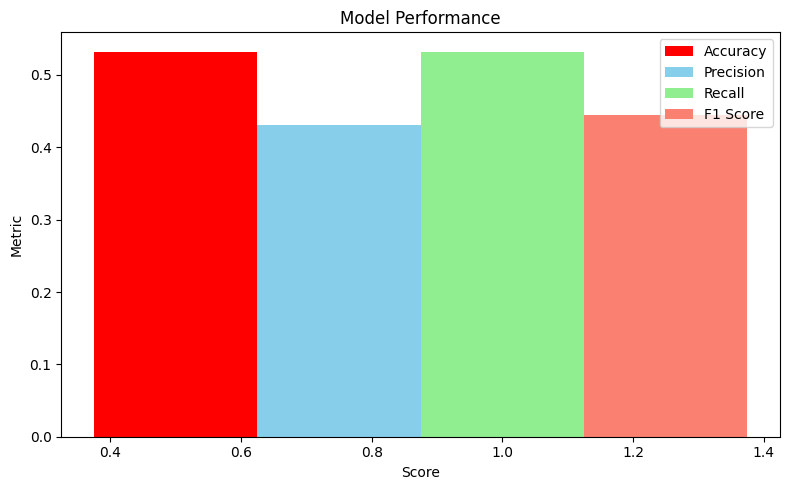

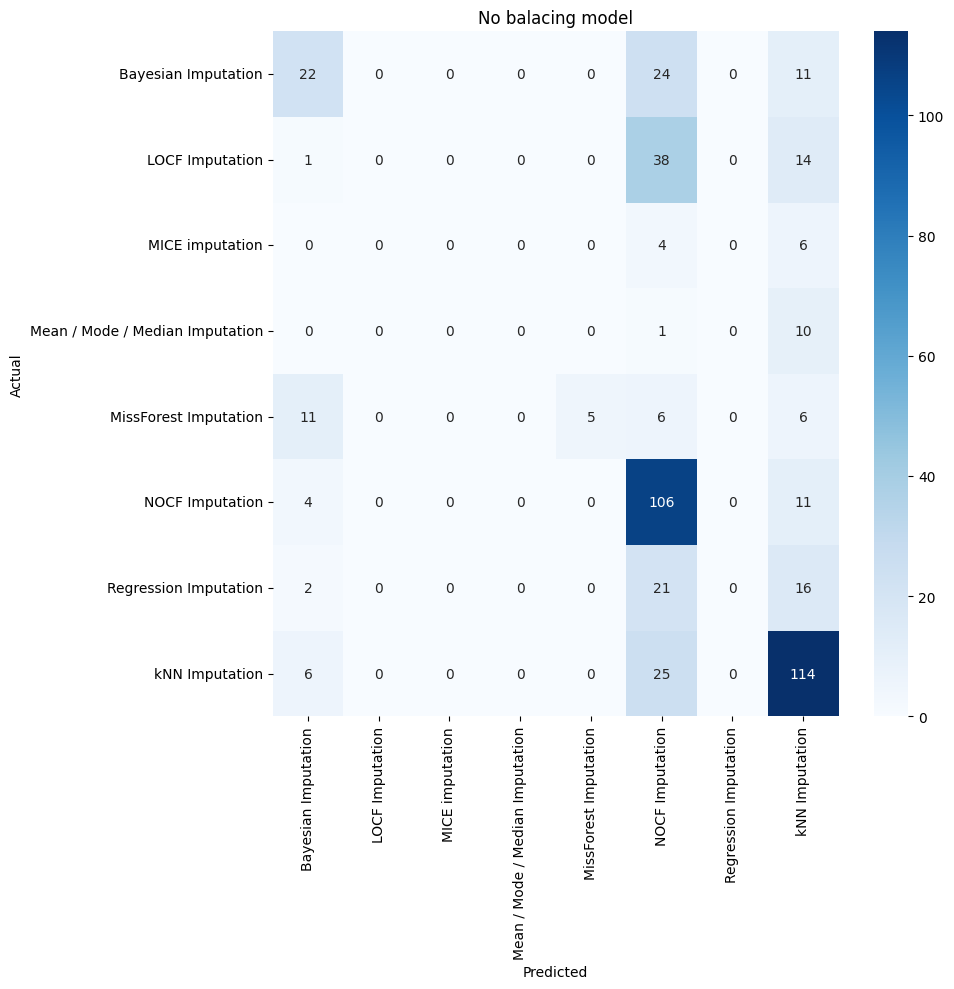

In [ ]:
# Analysis code for experiment 1 - Reducing class imbalance

# Create a bar graph for the inital models metrics
graph_metrics(metrics_dict, experiment1_stats_folder, "metrics_graph")

# Create a confusion matrix for the initial model
make_confusion_matrix(unencoded_labels, validation_labels, y_predictions, experiment1_stats_folder, no_balacing_model_label, "confusion_matrix.png")

#### Results - Reducing class imbalance

This experiment has shown that the class weighting method is more effective than all other methods as it produces better results in every metric. Its confusion matrix also displays far more diversity than the original models, showing that the balancing of the data is also improving the models diversity in predictions. Moving foward we will be implementing class weighting when training the model.

In [ ]:
# Set the metrics to be used in the next experiment for comparison
prev_metrics_dict.append(metrics_dict)
prev_labels_list.append(no_balacing_model_label)

## Experiment 2 - Class weighting

In this experiment we use the class weighting technique which the random forest classifier is built-in with. Class weighting will assess the disproportionality in the classess represented in the dataset and assign greater weight to class with less representation. This weighting of a class will proportionally impact the learning of the model when the model is trained on an instance of that class (class with higher weighting will have greater impact on the learning of the model)

#### Variable initialisation - Class weighting

In [ ]:
# Variable initalisation for experiment 2 - Class weighting

# Initialse variables
class_weighting_model_label = "Class weighting model"

# Set folders for the saving of stats, models and figures
experiment2_stats_folder = os.path.join(machine_learning_folder, "experiement2_model_stats")
experiment2_model_folder = os.path.join(machine_learning_folder, "experiement2_model")
metrics_save_file = os.path.join(experiment1_stats_folder, "metrics.csv")
encoded_classess_save_file = os.path.join(experiment1_stats_folder, "encoded_classess.csv")


# Create folders if they don't exist
if not os.path.exists(experiment2_stats_folder):
    os.makedirs(experiment2_stats_folder)
    print(f"Folder '{experiment2_stats_folder}' created.")


if not os.path.exists(experiment2_model_folder):
    os.makedirs(experiment2_model_folder)
    print(f"Folder '{experiment2_model_folder}' created.")

#### Running experiment - Class weighting

In [ ]:
# Running the code for experiment 2 - Class weighting
%%capture

print(f"\n\nRunning Model 2 : {no_balacing_model_label} --------------------------------------------------")

y_predictions = None
best_model = None
accuracy = 0.0
train_data = None
validation_labels = None


for i in range(0, 500):
  label_encoder = LabelEncoder()
  train_dataset, validation_dataset = load_dataset_for_missingness_mechansim(
      mcar_path = mcar_path,
      mar_path = mar_path,
      mnar_path = mnar_path,
      imputation_stats_folder = imputation_stats_folder,
      imputation_stats_file = imputation_stats_file,
      is_oversampled = False,
      label_encoder = label_encoder,
      test_size = test_size,
      random_state = random_state,
      is_filtered = is_filtered
  );

  # Base model
  model = RandomForestClassifier(random_state=42);

  # Parameter grid
  param_dist = {
      'n_estimators': [i for i in range(0, 200)],
      'max_depth': [None] + [i for i in range(1, 50)],
      'min_samples_split': [i for i in range(1, 50)],
      'min_samples_leaf': [i for i in range(1, 50)],
      'max_features': ['auto', 'sqrt', 'log2'],
      'bootstrap': [True, False],
      'max_leaf_nodes': [i for i in range(0, 200)],
      'warm_start': [True, False],
      'max_samples': [i for i in range(0, 200)],
      'class_weight': ['balanced', 'balanced_subsample']
  }

  # Randomized Search
  random_search = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=50,
                                    cv=5,
                                    verbose=1,
                                    random_state=42,
                                    n_jobs=-1);

  # Fit the model
  random_search.fit(train_dataset[0], train_dataset[1])

  # Best model
  model = random_search.best_estimator_

  # Evaluate
  y_pred = model.predict(validation_dataset[0])


  if accuracy is None or accuracy < accuracy_score(validation_dataset[1], y_pred):
    accuracy = accuracy_score(validation_dataset[1], y_pred)
    best_model = model
    y_predictions = y_pred
    train_data = train_dataset[1]
    validation_labels = validation_dataset[1]


  del random_search, train_dataset, validation_dataset


  gc.collect()


# Get the info for the best model
unencoded_labels = np.unique(label_encoder.inverse_transform(train_data))

precision = precision_score(validation_labels, y_predictions, average='weighted')
recall = recall_score(validation_labels, y_predictions, average='weighted')
f1 = f1_score(validation_labels, y_predictions, average='weighted')

metrics_dict = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

# Save Model metrics
df = pd.DataFrame(metrics_dict, index=[0])
df.to_csv(metrics_save_file, mode='a', index=False, header=not os.path.exists(experiment1_stats_folder))

# Save encoded classes
series = pd.Series(label_encoder.classes_)
series.to_json(encoded_classess_save_file, orient='values')

# Save the Model
joblib.dump(best_model, os.path.join(experiment2_model_folder, 'best_random_forest_model.pkl'))

In [ ]:
# Display results
print(f"\nAccuracy: {accuracy}\n")


Accuracy: 0.5387931034482759



#### Analyse experiment - Class weighting

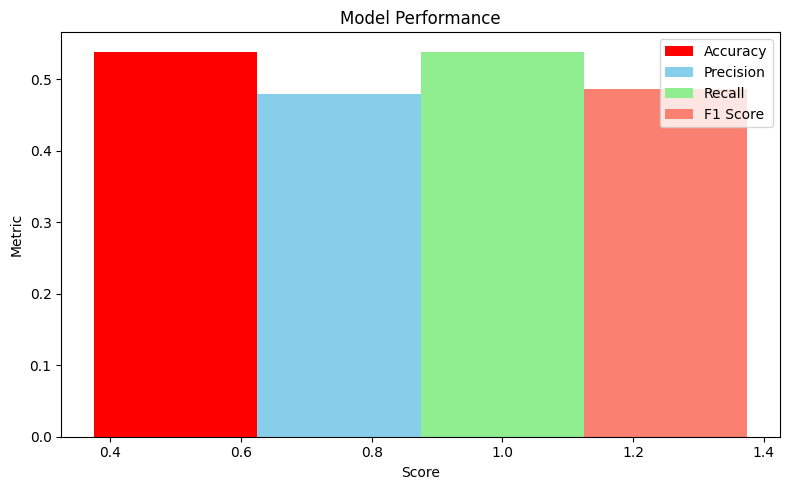

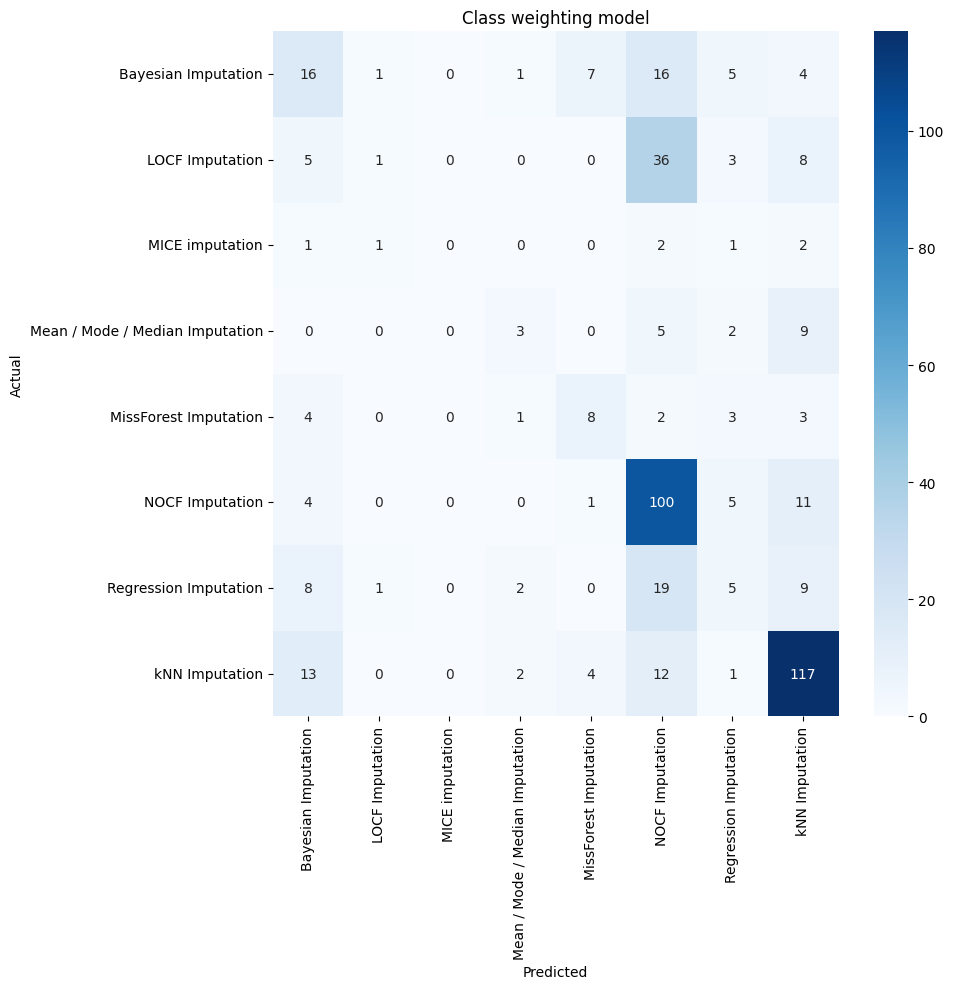

In [ ]:
# Analysis code for experiment 2 - Class weighting

# Create a bar graph for the inital models metrics
graph_metrics(metrics_dict, experiment2_stats_folder, "metrics_graph")

# Create a confusion matrix for the initial model
make_confusion_matrix(unencoded_labels, validation_labels, y_predictions, experiment2_stats_folder, class_weighting_model_label, "confusion_matrix.png")

#### Results - Class weighting

This experiment has shown that the class weighting method is more effective than all other methods as it produces better results in every metric. Its confusion matrix also displays far more diversity than the original models, showing that the balancing of the data is also improving the models diversity in predictions. Moving foward we will be implementing class weighting when training the model.

In [ ]:
# Set the metrics to be used in the next experiment for comparison
prev_metrics_dict.append(metrics_dict)
prev_labels_list.append(class_weighting_model_label)

## Experiment 3 - Oversampling (SMOTE)

In this experiment we use the overweighting technique SMOTE. SMOTE will assess the disproportionality in the classess represented in the data and generate new peaces of data until all classess are equally represented in the data. SMOTE uses the datasets already in the data to aritically generate new ones that are as close as possible to the originals they are based on as reduce the occurance of outliers or class overlapp.

#### Variable initialisation - Oversampling (SMOTE)

In [ ]:
# Variable initalisation for experiment 3 - Oversampling (SMOTE)

# Initialse variables
oversampling_model_label = "Oversampling (SMOTE) model"

# Set folders for the saving of stats, models and figures
experiment3_stats_folder = os.path.join(machine_learning_folder, "experiement3_model_stats")
experiment3_model_folder = os.path.join(machine_learning_folder, "experiement3_model")
metrics_save_file = os.path.join(experiment1_stats_folder, "metrics.csv")
encoded_classess_save_file = os.path.join(experiment1_stats_folder, "encoded_classess.csv")


# Create folders if they don't exist
if not os.path.exists(experiment3_stats_folder):
    os.makedirs(experiment3_stats_folder)
    print(f"Folder '{experiment3_stats_folder}' created.")


if not os.path.exists(experiment3_model_folder):
    os.makedirs(experiment3_model_folder)
    print(f"Folder '{experiment3_model_folder}' created.")

#### Running experiment - Oversampling (SMOTE)

In [ ]:
# Running the code for experiment 3 - Oversampling (SMOTE)
%%capture

print(f"\n\nRunning Model 3 : {no_balacing_model_label} --------------------------------------------------")

y_predictions = None
best_model = None
accuracy = 0.0
train_data = None
validation_labels = None


for i in range(0, 500):
  label_encoder = LabelEncoder()
  train_dataset, validation_dataset = load_dataset_for_missingness_mechansim(
      mcar_path = mcar_path,
      mar_path = mar_path,
      mnar_path = mnar_path,
      imputation_stats_folder = imputation_stats_folder,
      imputation_stats_file = imputation_stats_file,
      is_oversampled = True,
      label_encoder = label_encoder,
      test_size = test_size,
      random_state = random_state,
      is_filtered = is_filtered
  );

  # Base model
  model = RandomForestClassifier(random_state=42);

  # Parameter grid
  param_dist = {
      'n_estimators': [i for i in range(0, 200)],
      'max_depth': [None] + [i for i in range(1, 50)],
      'min_samples_split': [i for i in range(1, 50)],
      'min_samples_leaf': [i for i in range(1, 50)],
      'max_features': ['auto', 'sqrt', 'log2'],
      'bootstrap': [True, False],
      'max_leaf_nodes': [i for i in range(0, 200)],
      'warm_start': [True, False],
      'max_samples': [i for i in range(0, 200)]
  }

  # Randomized Search
  random_search = RandomizedSearchCV(estimator=model,
                                    param_distributions=param_dist,
                                    n_iter=50,
                                    cv=5,
                                    verbose=1,
                                    random_state=42,
                                    n_jobs=-1);

  # Fit the model
  random_search.fit(train_dataset[0], train_dataset[1])

  # Best model
  model = random_search.best_estimator_

  # Evaluate
  y_pred = model.predict(validation_dataset[0])


  if accuracy is None or accuracy < accuracy_score(validation_dataset[1], y_pred):
    accuracy = accuracy_score(validation_dataset[1], y_pred)
    best_model = model
    y_predictions = y_pred
    train_data = train_dataset[1]
    validation_labels = validation_dataset[1]


  del random_search, train_dataset, validation_dataset


  gc.collect()


# Get the info for the best model
unencoded_labels = np.unique(label_encoder.inverse_transform(train_data))

precision = precision_score(validation_labels, y_predictions, average='weighted')
recall = recall_score(validation_labels, y_predictions, average='weighted')
f1 = f1_score(validation_labels, y_predictions, average='weighted')

metrics_dict = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

# Save Model metrics
df = pd.DataFrame(metrics_dict, index=[0])
df.to_csv(metrics_save_file, mode='a', index=False, header=not os.path.exists(experiment1_stats_folder))

# Save encoded classes
series = pd.Series(label_encoder.classes_)
series.to_json(encoded_classess_save_file, orient='values')

# Save the Model
joblib.dump(best_model, os.path.join(experiment3_model_folder, 'best_random_forest_model.pkl'))

In [ ]:
# Display results
print(f"\nAccuracy: {accuracy}\n")


Accuracy: 0.5009363295880149



#### Analyse experiment - Oversampling (SMOTE)

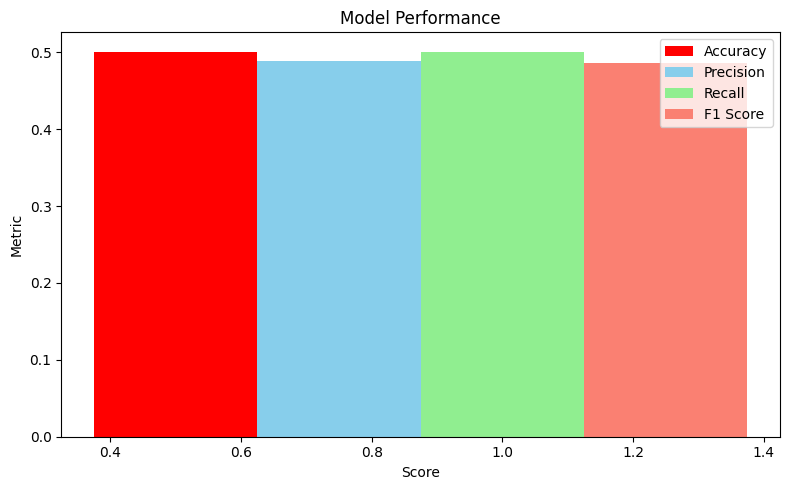

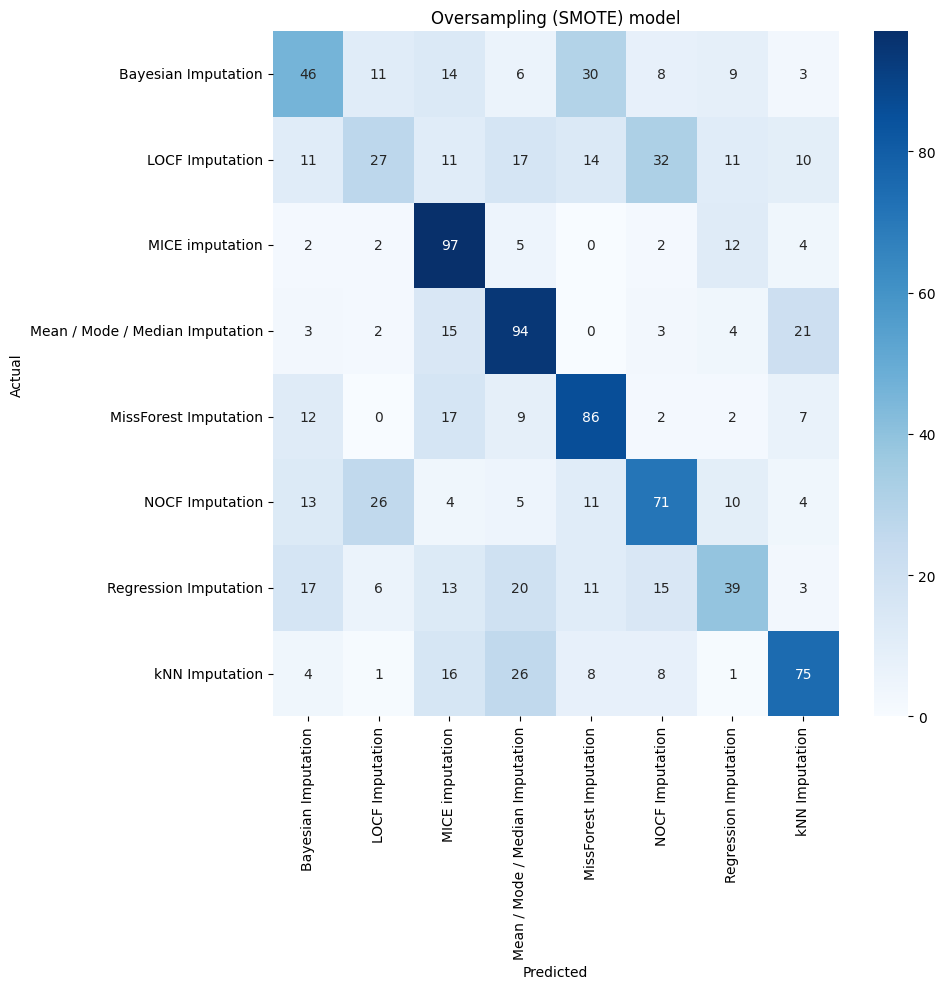

In [ ]:
# Analysis code for experiment 3 - Oversampling (SMOTE)

# Create a bar graph for the inital models metrics
graph_metrics(metrics_dict, experiment3_stats_folder, "metrics_graph")

# Create a confusion matrix for the initial model
make_confusion_matrix(unencoded_labels, validation_labels, y_predictions, experiment3_stats_folder, oversampling_model_label, "confusion_matrix.png")

#### Results - Oversampling (SMOTE)

This experiment has shown that the class weighting method is more effective than all other methods as it produces better results in every metric. Its confusion matrix also displays far more diversity than the original models, showing that the balancing of the data is also improving the models diversity in predictions. Moving foward we will be implementing class weighting when training the model.

In [ ]:
# Set the metrics to be used in the next experiment for comparison
prev_metrics_dict.append(metrics_dict)
prev_labels_list.append(oversampling_model_label)

# **Experiments Analysis**

In the previous section we perfomed experiments on the random forest model we chose to train our data by applying parameter search and optimisation on the model whilst being trained on datasets being class balanced via different techniques. These experiments produced results that were reccoreded and which will now be graphed and displayed for the comparison of these models and the comparison of the class balancing techniques applied in each experiment

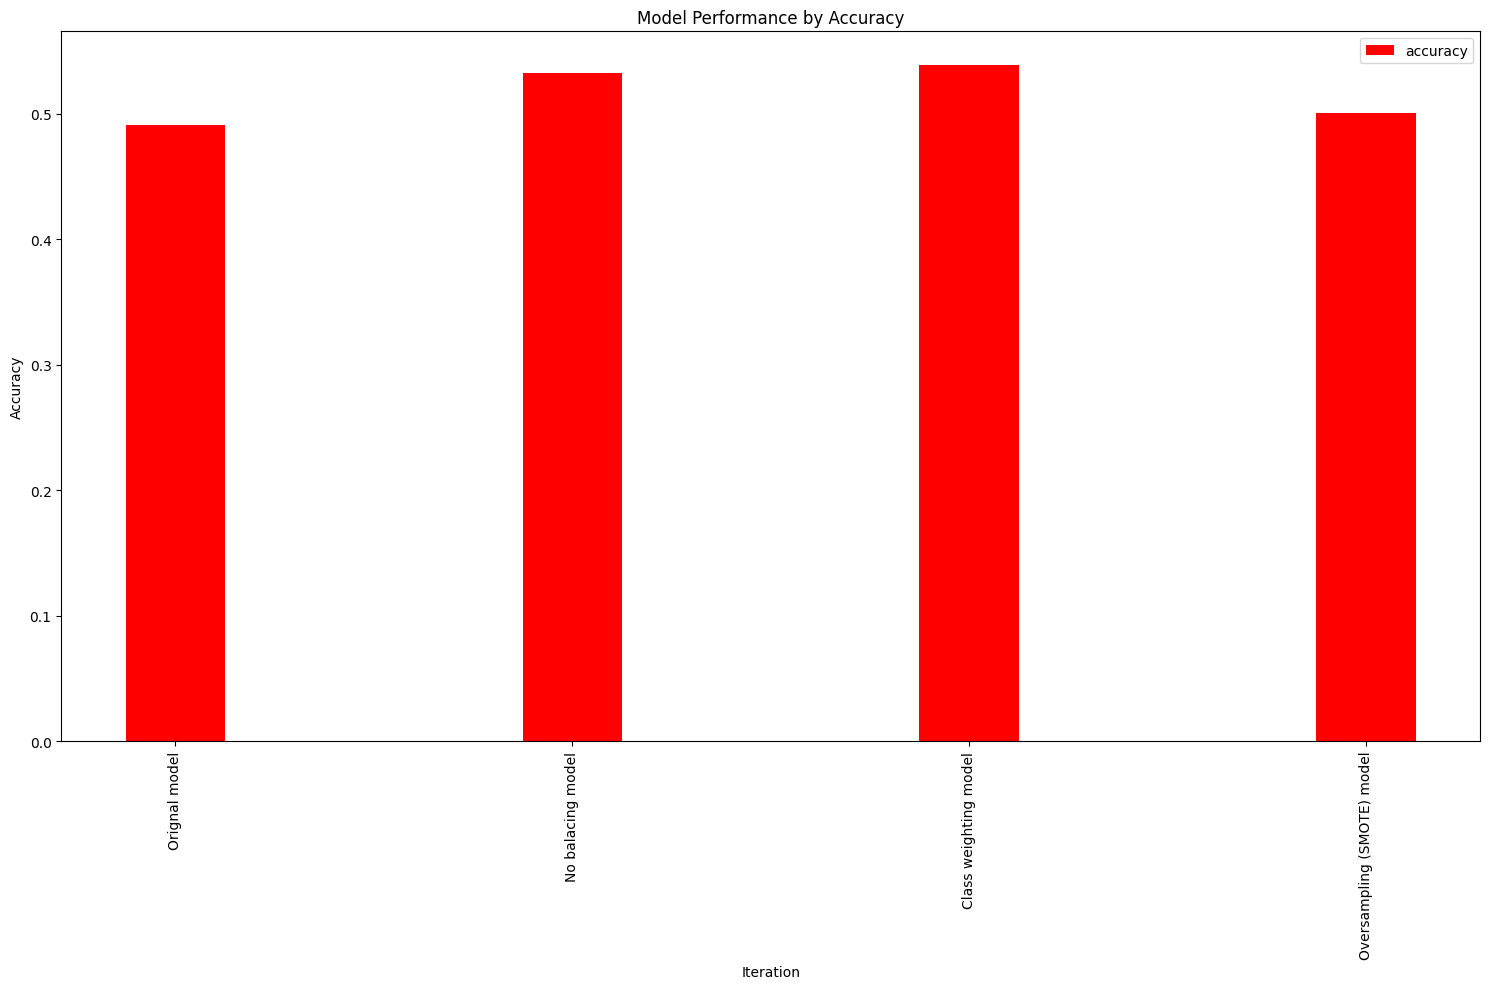

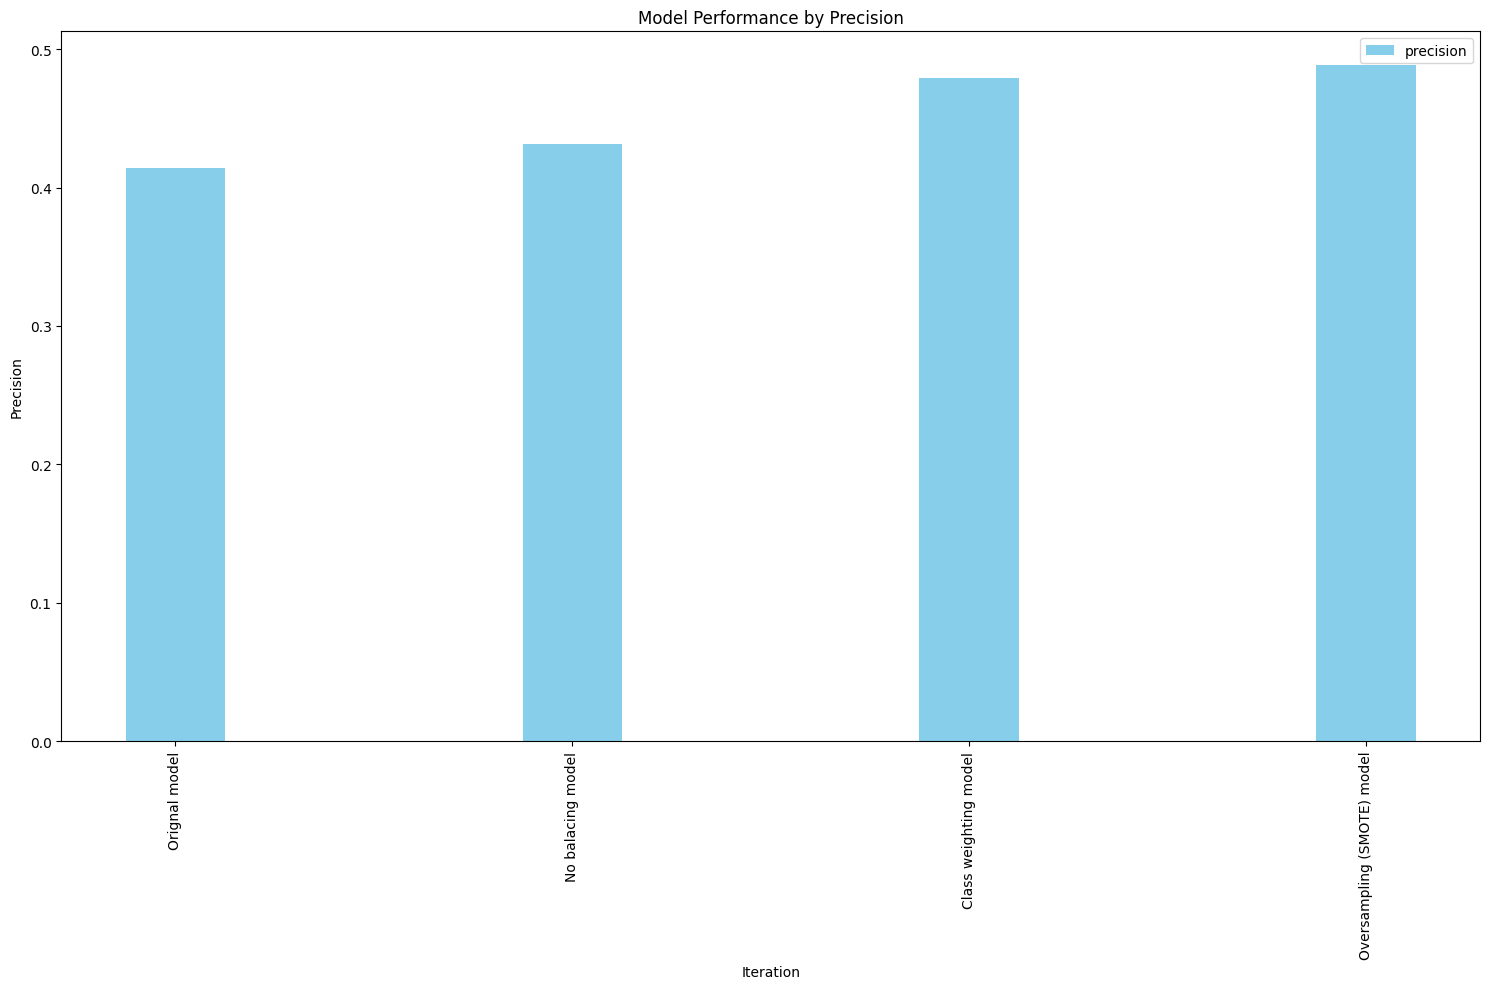

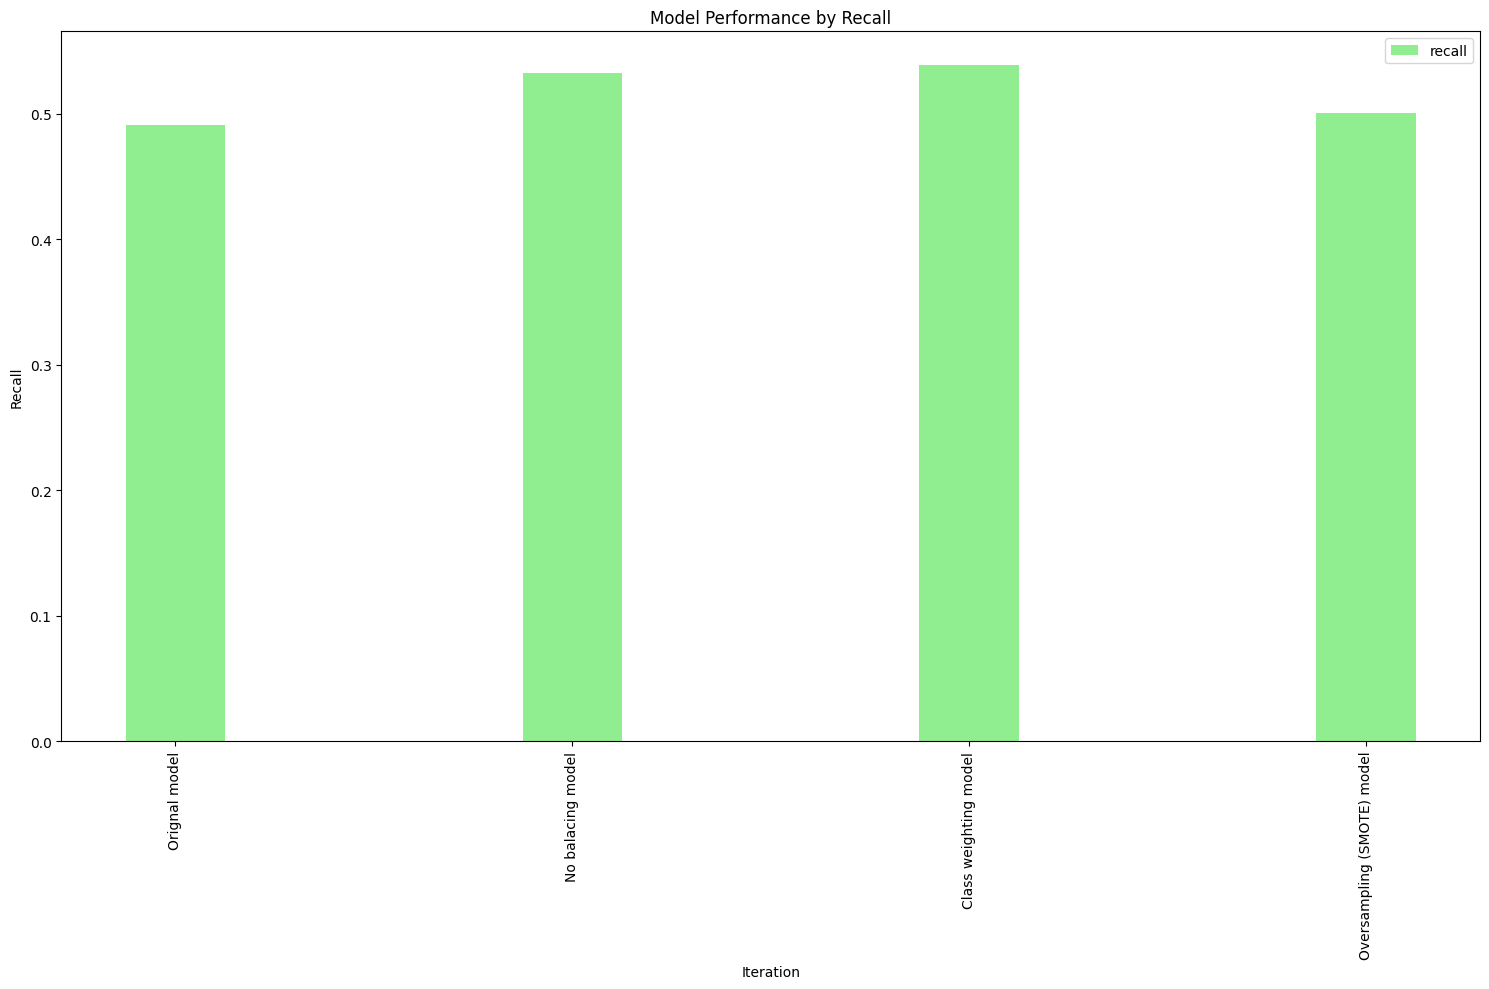

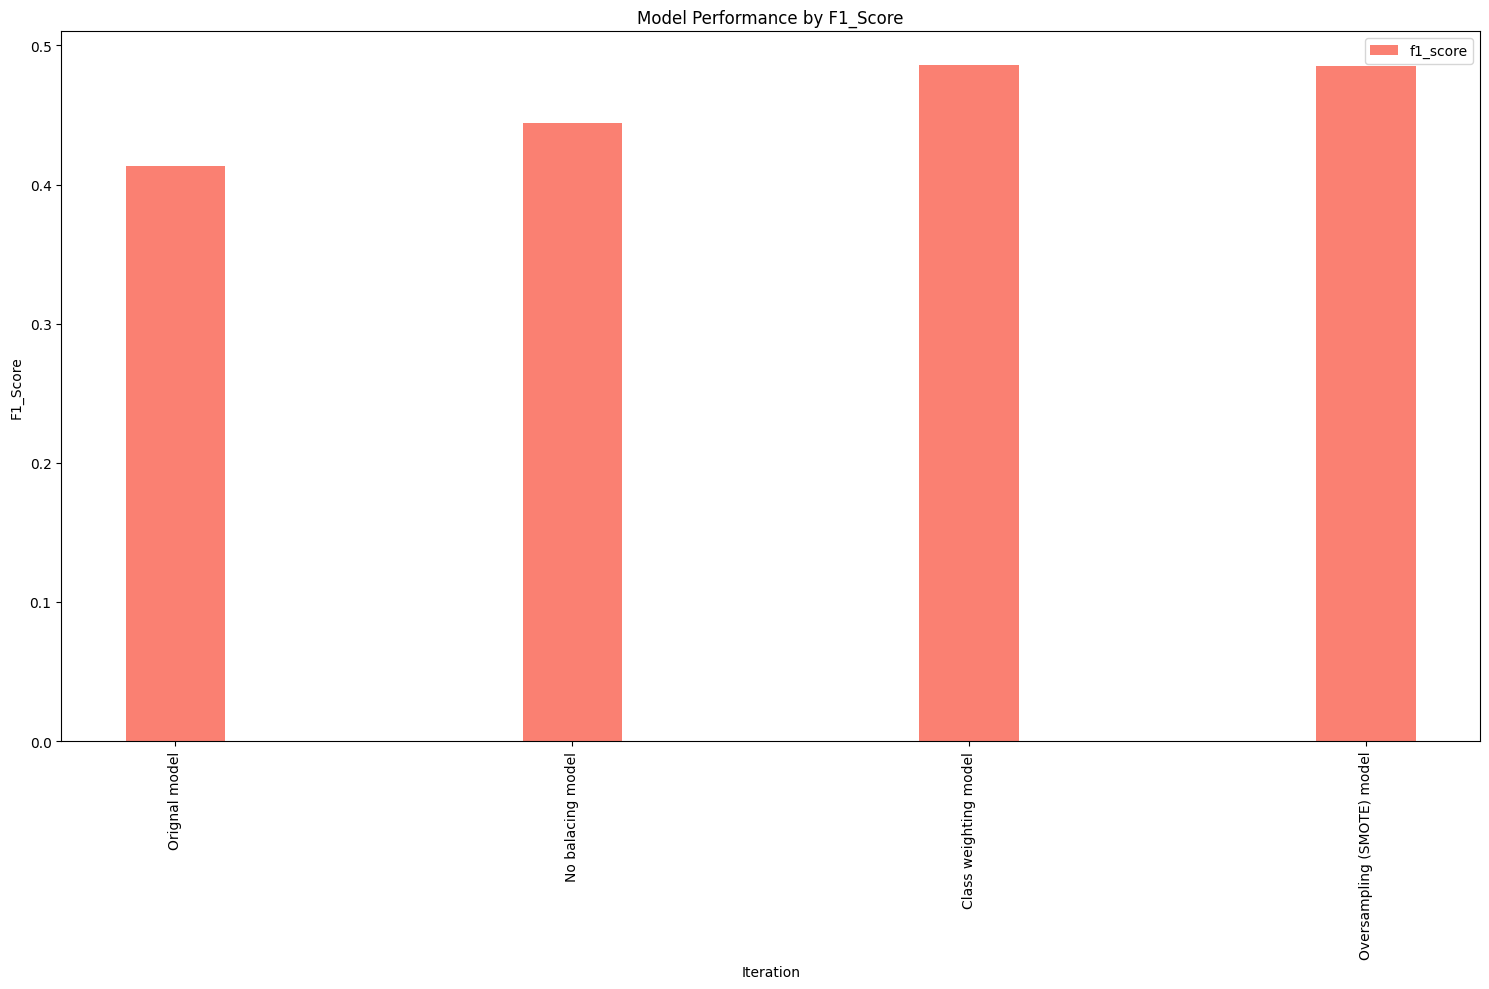

In [ ]:
# Experiments analysis

# Set folders for the saving of stats, models and figures
experiements_stats_folder = os.path.join(machine_learning_folder, "experiements_stats")


# Create folders if they don't exist
if not os.path.exists(experiements_stats_folder):
    os.makedirs(experiements_stats_folder)
    print(f"Folder '{experiements_stats_folder}' created.")


# Generate bar graphs to compare each experiment by comparing each of their individual metrics

# Create accuracy bar graph
graph_accuracy(prev_metrics_dict, prev_labels_list, experiements_stats_folder, "accuracy_bar_graph")


# Create precision bar graph
graph_precision(prev_metrics_dict, prev_labels_list, experiements_stats_folder, "accuracy_bar_graph")


# Create recall bar graph
graph_recall(prev_metrics_dict, prev_labels_list, experiements_stats_folder, "accuracy_bar_graph")


# Create F1-score bar graph
graph_f1_score(prev_metrics_dict, prev_labels_list, experiements_stats_folder, "accuracy_bar_graph")

# **Conclusion**

In these experiments to optimise a random forest classifier model we have discovered that the class weighting method applied to the model is the optimal method to handle the class imbalance in the data. Furthermore through the use of the random search we have determined the model (with class weighting) with the best validation accruacy and therefore the optimal model for our purposes. In the end after exaushting optimisation approaches we were able to acheive a validation accuracy of 58% which is 2% below our target accuracy